# Quick look at dynamic height and footprint

In [5]:
import scipy.io as sio
import numpy as np
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from pyresample import geometry, kd_tree
import gsw

In [6]:
# open dataset
ar7w_ds = xr.open_dataset("/Users/mzahn/data/Labrador_AR7W/igor_ds/AR7W_netcdf/igor_ar7w.nc")

# Remove duplicates

In [8]:
# remove duplicate profiles (lat/lon)
precision = 3  # 0.001 deg
coords_df = pd.DataFrame({
    "lat": np.round(ar7w_ds.latitude.values, 4),
    "lon": np.round(ar7w_ds.longitude.values, 4)
})

# keep first occurrence of each (lat, lon)
duplicate_mask = coords_df.duplicated()
print(f"Number of duplicate profiles: {duplicate_mask.sum()}")

ar7w_clean = ar7w_ds.isel(time=~duplicate_mask)

# swap to distance for plotting
# tmp_dist = (tmp.swap_dims({"time": "distance"}).sortby("distance"))

Number of duplicate profiles: 903


In [9]:
ar7w_1996 = ar7w_clean.sel(time='1996-05').isel(time=slice(None,-5))
ar7w_2024 = ar7w_clean.sel(time='2024')

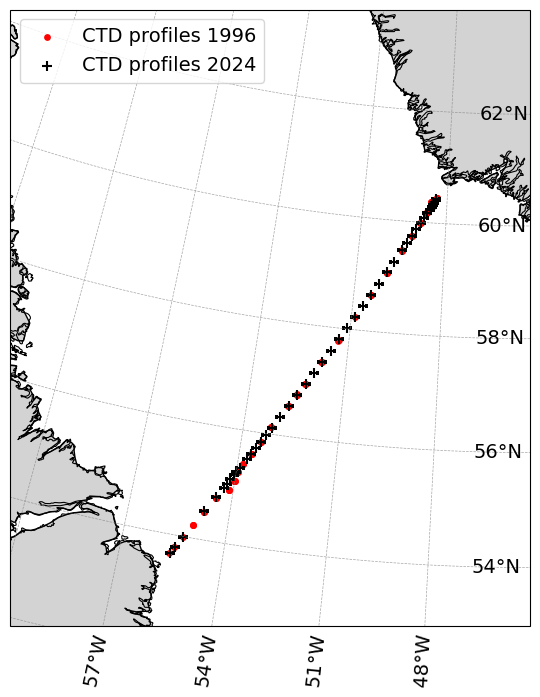

In [11]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
ax.set_extent([-60, -45, 53, 63], crs=ccrs.PlateCarree())
# ax.set_extent([-51, -50, 58, 59], crs=ccrs.PlateCarree())

# Plot points for 1996
ax.scatter(
    ar7w_1996.longitude.values,
    ar7w_1996.latitude.values,
    s=60,
    color="red", marker='.',
    transform=ccrs.PlateCarree(),
    label='CTD profiles 1996')

# Plot points for 2024
ax.scatter(
    ar7w_2024.longitude.values,
    ar7w_2024.latitude.values,
    s=50,
    color="k", marker='+',
    transform=ccrs.PlateCarree(),
    label='CTD profiles 2024')

# Title and legend
# plt.title("Matching AR7W Profiles: 1993 and 2024\nSatellite SLA 2024-06-12")
plt.legend(loc='upper left')
plt.show()

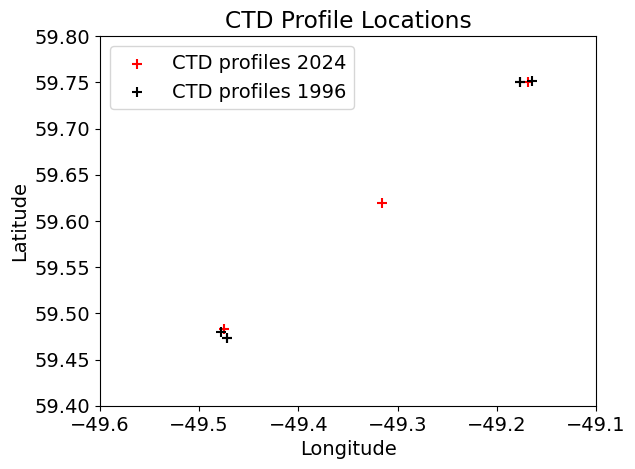

In [15]:
plt.scatter(
    ar7w_2024.longitude.values,
    ar7w_2024.latitude.values,
    s=50,
    color="r", marker='+',
    label='CTD profiles 2024')
plt.scatter(
    ar7w_1996.longitude.values,
    ar7w_1996.latitude.values,
    s=50,
    color="k", marker='+',
    label='CTD profiles 1996')
plt.xlim(-49.6,-49.1)
plt.ylim(59.4,59.8)
plt.legend()
plt.title('CTD Profile Locations')
plt.ylabel('Latitude')
plt.xlabel('Longitude');

In [16]:
tmp = ar7w_1996.where(ar7w_1996.latitude>59.45,drop=True)
tmp = tmp.where(tmp.latitude<59.55,drop=True)
tmp = tmp.where(tmp.longitude<-49.4,drop=True)
test = tmp.where(tmp.longitude>-49.6,drop=True)

In [17]:
print(test.latitude.values)
print(test.longitude.values)
print(test.time.values)

[59.4798 59.4733 59.473 ]
[-49.4782 -49.4717 -49.472 ]
['1996-05-23T15:29:01.935479774' '1996-05-23T15:29:01.935486964'
 '1996-05-23T15:29:01.935486964']


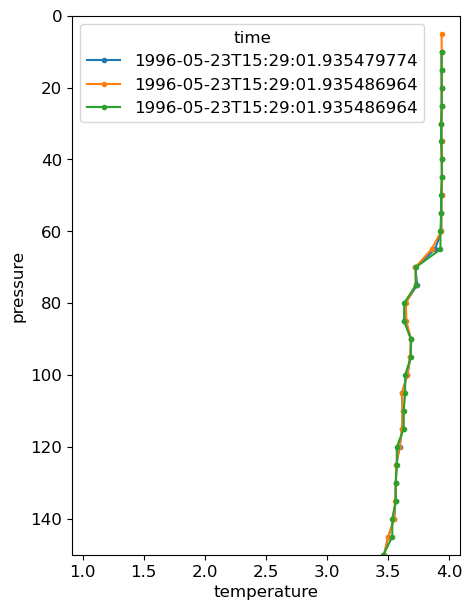

In [18]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(figsize=(5, 7))
test.temperature.plot(ax=ax,y='pressure',marker='.',hue='time');
ax.set_ylim(150,0);

# Calculate dynamic height for 1996 and 2024

### Find location of 1996 profiles that match 2024 profile locations

In [26]:
# collocate ctd profiles using pyresample (nearest neighbor)

# --- extract coordinates ---
lats_1996, lons_1996 = ar7w_1996.latitude.values, ar7w_1996.longitude.values
lats_2024, lons_2024 = ar7w_2024.latitude.values, ar7w_2024.longitude.values

# --- define swaths (scattered point geometry) ---
swath_1996  = geometry.SwathDefinition(lons=lons_1996,  lats=lats_1996)
swath_2024 = geometry.SwathDefinition(lons=lons_2024, lats=lats_2024)

# --- nearest neighbor search ---
idx, dist, idx_valid, dist_valid = kd_tree.get_neighbour_info(
    source_geo_def=swath_2024,
    target_geo_def=swath_1996,
    radius_of_influence=5e4,
    neighbours=1)

# a bunch of ctds are out of range, so drop those ones (=last index of wod_ctd_ds array)
# idx_valid = idx_valid[np.where(idx_valid!=len(wod_ctd_2024.time))]

# ar7w_1996_match = ar7w_1996.isel(time=idx_valid)
ar7w_2024_match = ar7w_2024.isel(time=idx_valid)

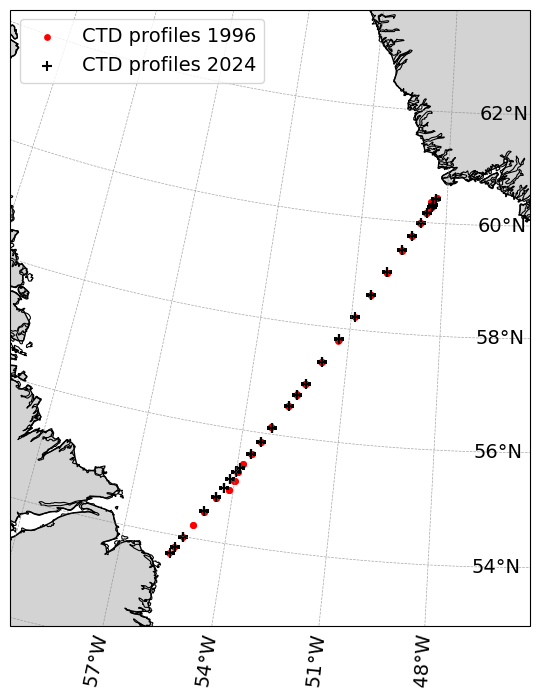

In [28]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
ax.set_extent([-60, -45, 53, 63], crs=ccrs.PlateCarree())
# ax.set_extent([-51, -50, 58, 59], crs=ccrs.PlateCarree())

# Plot points for 1996
ax.scatter(
    ar7w_1996.longitude.values,
    ar7w_1996.latitude.values,
    s=60,
    color="red", marker='.',
    transform=ccrs.PlateCarree(),
    label='CTD profiles 1996')

# Plot points for 2024
ax.scatter(
    ar7w_2024_match.longitude.values,
    ar7w_2024_match.latitude.values,
    s=50,
    color="k", marker='+',
    transform=ccrs.PlateCarree(),
    label='CTD profiles 2024')

# Title and legend
# plt.title("Matching AR7W Profiles: 1993 and 2024\nSatellite SLA 2024-06-12")
plt.legend(loc='upper left')
plt.show()

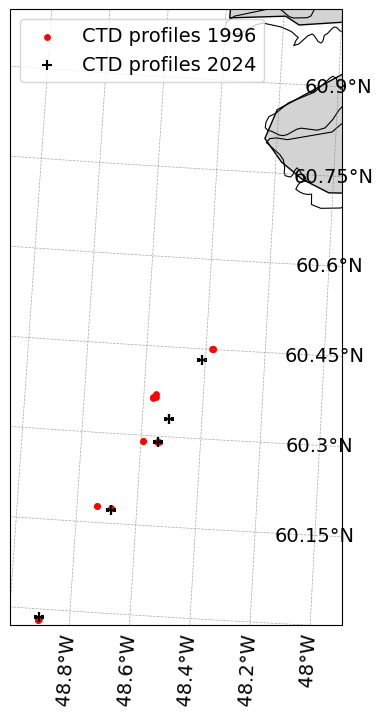

In [30]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
# ax.set_extent([-60, -45, 53, 63], crs=ccrs.PlateCarree())
ax.set_extent([-49, -48, 60, 61], crs=ccrs.PlateCarree())

# Plot points for 1996
ax.scatter(
    ar7w_1996.longitude.values,
    ar7w_1996.latitude.values,
    s=60,
    color="red", marker='.',
    transform=ccrs.PlateCarree(),
    label='CTD profiles 1996')

# Plot points for 2024
ax.scatter(
    ar7w_2024_match.longitude.values,
    ar7w_2024_match.latitude.values,
    s=50,
    color="k", marker='+',
    transform=ccrs.PlateCarree(),
    label='CTD profiles 2024')

# Title and legend
# plt.title("Matching AR7W Profiles: 1993 and 2024\nSatellite SLA 2024-06-12")
plt.legend(loc='upper left')
plt.show()

In [32]:
def compute_dyn_height(ds):
    dyn, lat_list, lon_list = [], [], []

    for i in range(len(ds.time)):
        prof = ds.isel(time=i)
        P, T, S = prof.pressure.values, prof.temperature.values, prof.salinity.values
        lat, lon = prof.latitude.values, prof.longitude.values

        mask = ~np.isnan(T) & ~np.isnan(S) & ~np.isnan(P)
        SA = gsw.SA_from_SP(S[mask], P[mask], lon, lat)
        CT = gsw.CT_from_t(SA, T[mask], P[mask])
        P_ref = P[~np.isnan(T)][-1]
        dyn_prof = gsw.geo_strf_dyn_height(SA, CT, P[mask], P_ref)

        # print(P_ref)
        # P_ref = ds.bottom_depth.values*-1
        
        dyn.append(dyn_prof)
        lat_list.append(lat); lon_list.append(lon)

    # divide by g to convert from m^2/s^2 to m
    dyn_surface_m = np.array([d[0] for d in dyn]) / 9.81

    return xr.DataArray(
        dyn_surface_m,
        dims=["time"],
        coords={"time": ds.time.values, "lat": ("time", lat_list), "lon": ("time", lon_list)},
        name="dynamic_height",
        attrs={"units": "m"})

In [34]:
ar7w_1996_dynH = compute_dyn_height(ar7w_1996)
ar7w_2024_dynH = compute_dyn_height(ar7w_2024_match)

In [36]:
# sort by lat
ar7w_1996_dynH = ar7w_1996_dynH.sortby('lat')
ar7w_2024_dynH = ar7w_2024_dynH.sortby('lat')

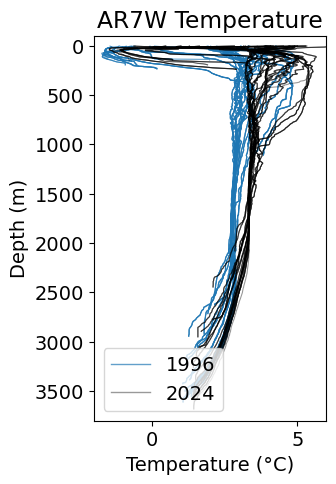

In [38]:
import matplotlib.lines as mlines
fig, ax = plt.subplots(figsize=(3, 5))

ar7w_1996.temperature.plot(y='pressure', hue='time', color='tab:blue', alpha=0.7, linewidth=0.8, ax=ax, add_legend=False)
ar7w_2024_match.temperature.plot(y='pressure', hue='time', color='k', linewidth=0.8, alpha=0.4, ax=ax, add_legend=False)
ax.set_xlim(-2, 6); ax.set_ylim(3800, -100); ax.set_xlabel("Temperature (°C)"); ax.set_ylabel("Depth (m)")

# Custom legend
line1 = mlines.Line2D([], [], color='tab:blue', alpha=0.7, linewidth=1, label='1996')
line2 = mlines.Line2D([], [], color='k', alpha=0.4, linewidth=1, label='2024')
ax.legend(handles=[line1, line2], loc='lower left')

ax.set_title("AR7W Temperature")
plt.show()

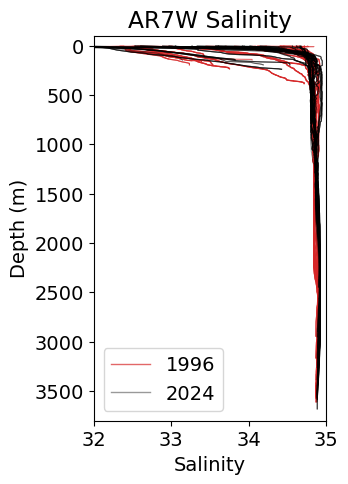

In [40]:
import matplotlib.lines as mlines
fig, ax = plt.subplots(figsize=(3, 5))

ar7w_1996.salinity.plot(y='pressure', hue='time', color='tab:red', alpha=0.7, linewidth=0.8, ax=ax, add_legend=False)
ar7w_2024_match.salinity.plot(y='pressure', hue='time', color='k', linewidth=0.8, alpha=0.4, ax=ax, add_legend=False)
ax.set_xlim(32, 35); ax.set_ylim(3800, -100); ax.set_xlabel("Salinity"); ax.set_ylabel("Depth (m)")

# Custom legend
line1 = mlines.Line2D([], [], color='tab:red', alpha=0.7, linewidth=1, label='1996')
line2 = mlines.Line2D([], [], color='k', alpha=0.4, linewidth=1, label='2024')
ax.legend(handles=[line1, line2], loc='lower left')

ax.set_title("AR7W Salinity")
plt.show()

### Plot dynamic height across transect

In [43]:
from pyproj import Geod

g = Geod(ellps="WGS84")

lat = ar7w_1996_dynH["lat"]
lon = ar7w_1996_dynH["lon"]
dim = lat.dims[0]

distances = [0.0]  # first point = 0

# Compute distances between consecutive profiles
segment_distances = []
for i in range(len(lat) - 1):
    _, _, d = g.inv(lon[i].item(), lat[i].item(), lon[i+1].item(), lat[i+1].item())
    segment_distances.append(d / 1000.0)  # convert m → km

# Cumulative distance with first profile at 0 km
distance_array = np.insert(np.cumsum(segment_distances), 0, 0.0)

# Add as a new coordinate
ar7w_1996_dynH = ar7w_1996_dynH.assign_coords(
    distance_along_transect=xr.DataArray(
        distance_array,
        dims=[dim],
        coords={dim: lat[dim]},
        attrs={
            "units": "km",
            "description": "Cumulative distance along transect"}))

In [75]:
# remove outliers
ar7w_1996_dynH[-7:-3] = np.nan
ar7w_2024_dynH[-7:-3] = np.nan

In [83]:
# remove nans
ar7w_1996_dynH = ar7w_1996_dynH.dropna(dim="time")
ar7w_2024_dynH = ar7w_2024_dynH.dropna(dim="time")

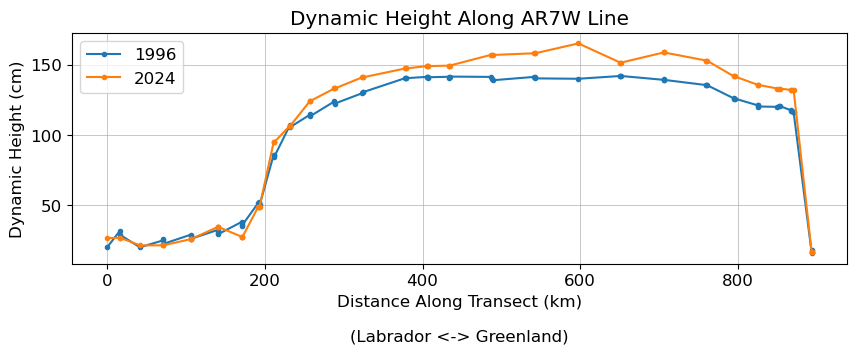

In [133]:
plt.rcParams['font.size'] = 12
plt.figure(figsize=[10,3])

plt.plot(ar7w_1996_dynH.distance_along_transect, ar7w_1996_dynH.values*100, marker='.', label='1996')
plt.plot(ar7w_1996_dynH.distance_along_transect, ar7w_2024_dynH.values*100, marker='.', label='2024')

# plt.plot(ar7w_1996_dynH.distance_along_transect, ar7w_1996_dynH.values, label='1996')
# plt.plot(ar7w_1996_dynH.distance_along_transect, ar7w_2024_dynH.values, label='2024')
plt.grid(linewidth=0.5)

# plt.ylim(0.5,1.5)
# plt.xlim(850,900)

plt.ylabel('Dynamic Height (cm)')
plt.xlabel('Distance Along Transect (km)\n\n(Labrador <-> Greenland)')
plt.title('Dynamic Height Along AR7W Line')

plt.legend();

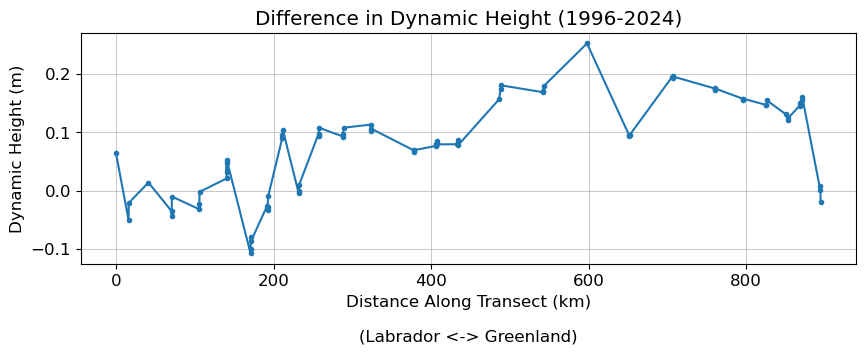

In [91]:
plt.rcParams['font.size'] = 12
plt.figure(figsize=[10,3])

diff = ar7w_2024_dynH.values - ar7w_1996_dynH.values

plt.plot(ar7w_1996_dynH.distance_along_transect, diff, marker='.')
plt.grid(linewidth=0.5)

# plt.ylim(0.5,1.5)

plt.ylabel('Dynamic Height (m)')
plt.xlabel('Distance Along Transect (km)\n\n(Labrador <-> Greenland)')
plt.title('Difference in Dynamic Height (1996-2024)');

In [113]:
diff_new = xr.DataArray(
    data=diff,coords=ar7w_1996_dynH.coords,dims=ar7w_1996_dynH.dims)

In [119]:
diff_new = diff_new.swap_dims({"time": "distance_along_transect"})

In [123]:
# interpolate/smooth difference
dist_interp_range = np.arange(0,900,5)
diff_smooth = diff_new.interp(distance_along_transect=dist_interp_range)

In [125]:
diff_smooth

<xarray.DataArray (distance_along_transect: 180)> Size: 1kB
array([ 0.06411636,  0.0282496 , -0.00761716, -0.04348392, -0.01563015,
       -0.00868373, -0.00173731,  0.00520912,  0.01215554,  0.00758989,
       -0.00076314, -0.00911618, -0.01746921, -0.02582224, -0.03417527,
       -0.0126221 , -0.01574609, -0.01887007, -0.02199406, -0.02511805,
       -0.02824204, -0.03136603,  0.00054694,  0.00389633,  0.00724572,
        0.01059511,  0.0139445 ,  0.01729389,  0.02064328,  0.0292948 ,
        0.00276608, -0.02376264, -0.05029137, -0.07682009, -0.10334881,
       -0.07567776, -0.06093066, -0.04618355, -0.03143645,  0.0007701 ,
        0.02864776,  0.05652541,  0.08440307,  0.08672244,  0.05975139,
        0.03278034,  0.00580928,  0.01889955,  0.0366357 ,  0.05437186,
        0.07210801,  0.08984417,  0.10657462,  0.10410042,  0.10162622,
        0.09915201,  0.09667781,  0.09420361,  0.10800898,  0.10875789,
        0.1095068 ,  0.11025572,  0.11100463,  0.11175354,  0.11250246,
        0.10539865,  0.10195786,  0.09851707,  0.09507628,  0.0916355 ,
        0.08819471,  0.08475392,  0.08131313,  0.07787234,  0.07443155,
        0.07099076,  0.06973194,  0.07105846,  0.07238498,  0.0737115 ,
        0.07503802,  0.07636454,  0.07933422,  0.07937627,  0.07941832,
        0.07946038,  0.07950243,  0.07903181,  0.08658266,  0.09413351,
        0.10168436,  0.10923521,  0.11678606,  0.12433692,  0.13188777,
        0.13943862,  0.14698947,  0.15454032,  0.18004211,  0.17893589,
        0.17782967,  0.17672345,  0.17561723,  0.17451101,  0.17340479,
        0.17229857,  0.17119235,  0.17008613,  0.16897991,  0.18181135,
        0.18846013,  0.19510891,  0.20175769,  0.20840647,  0.21505525,
        0.22170403,  0.22835281,  0.23500159,  0.24165037,  0.24829915,
        0.24573913,  0.23102493,  0.21631073,  0.20159653,  0.18688233,
        0.17216812,  0.15745392,  0.14273972,  0.12802552,  0.11331132,
        0.09859712,  0.10082553,  0.11005899,  0.11929246,  0.12852593,
        0.13775939,  0.14699286,  0.15622633,  0.16545979,  0.17469326,
        0.18392673,  0.19316019,  0.19425408,  0.19231998,  0.19038587,
        0.18845177,  0.18651766,  0.18458356,  0.18264945,  0.18071534,
        0.17878124,  0.17684713,  0.17342883,  0.1726236 ,  0.17013817,
        0.16765274,  0.16516731,  0.16268188,  0.16019644,  0.15771101,
        0.15605047,  0.15421372,  0.15237698,  0.15054023,  0.14870348,
        0.14686674,  0.15072895,  0.14579488,  0.14086081,  0.13592674,
        0.13099267,  0.12693439,  0.1341883 ,  0.14144222,  0.15327422,
        0.1328002 ,  0.09797489,  0.06314957,  0.02832426,         nan])
Coordinates:
    lat                      (distance_along_transect) float64 1kB 53.67 ... nan
    lon                      (distance_along_transect) float64 1kB -55.56 ......
  * distance_along_transect  (distance_along_transect) int64 1kB 0 5 ... 890 895

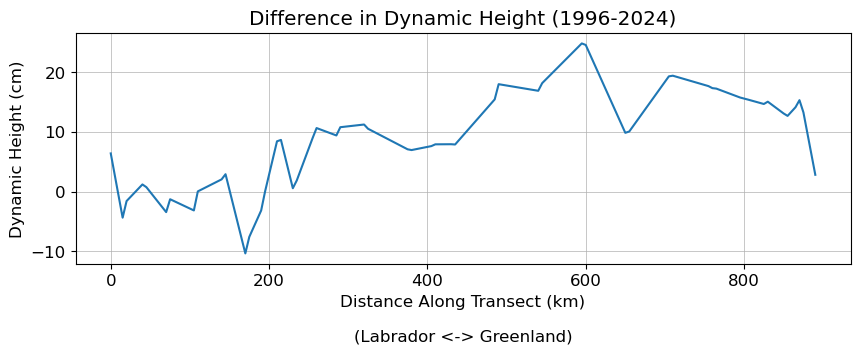

In [131]:
plt.rcParams['font.size'] = 12
plt.figure(figsize=[10,3])

plt.plot(diff_smooth.distance_along_transect, diff_smooth.values*100)
plt.grid(linewidth=0.5)

# plt.ylim(0.5,1.5)

plt.ylabel('Dynamic Height (cm)')
plt.xlabel('Distance Along Transect (km)\n\n(Labrador <-> Greenland)')
plt.title('Difference in Dynamic Height (1996-2024)');

## Collocate SLA in satellite data

### first calculate difference in SLA from 1996-2024

In [135]:
ssh_1996 = xr.open_dataset('/Users/mzahn/data/SSH/cmems_ssh_yearly/ssh_cmems_l4_0pt125deg_50N_65N_60W_40W_1996.nc')
ssh_2024 = xr.open_dataset('/Users/mzahn/data/SSH/cmems_ssh_yearly/ssh_cmems_l4_0pt125deg_50N_65N_60W_40W_2024.nc')

In [137]:
ssh_1996_day = ssh_1996.sla.sel(time='1996-05-20') # midpoint in CTD profile sampling period

In [139]:
ssh_2024_day = ssh_2024.sla.sel(time='2024-05-20') # midpoint in CTD profile sampling period

In [141]:
sla_diff_cm = (ssh_2024_day - ssh_1996_day)*100

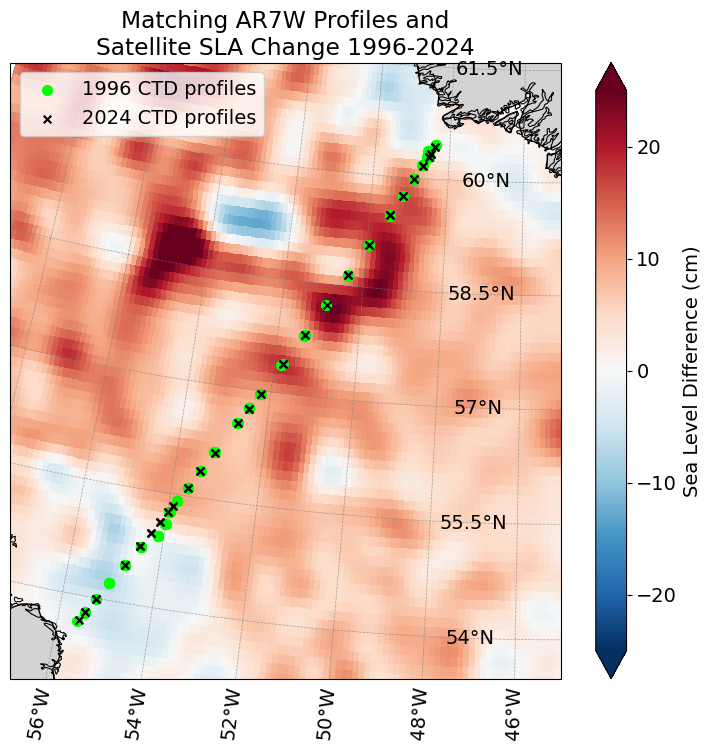

In [185]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
# ax.set_extent([-54, -44, 57, 62], crs=ccrs.PlateCarree())
# ax.set_extent([-65, -45, 50, 65], crs=ccrs.PlateCarree())
ax.set_extent([-57, -45, 53.5, 61], crs=ccrs.PlateCarree())

# plot ssh
sla_diff_cm.plot(vmin=-25,vmax=25,cmap='RdBu_r',transform=ccrs.PlateCarree(),cbar_kwargs={'label': 'Sea Level Difference (cm)'})

# Plot points for 1993
ax.scatter(
    ar7w_1996.longitude.values,
    ar7w_1996.latitude.values,
    s=50,
    color="lime", marker='o',
    transform=ccrs.PlateCarree(),
    label='1996 CTD profiles')

# Plot points for 2024
ax.scatter(
    ar7w_2024_match.longitude.values,
    ar7w_2024_match.latitude.values,
    s=30,
    color="k", marker='x',
    transform=ccrs.PlateCarree(),
    label='2024 CTD profiles')

# Title and legend
plt.title("Matching AR7W Profiles and\nSatellite SLA Change 1996-2024")
plt.legend(loc='upper left')
plt.show()

## Collocate CTD profiles with SLA measurement

Interpolate to closest CTD location

In [158]:
ar7w_1996_dynH

<xarray.DataArray 'dynamic_height' (time: 79)> Size: 632B
array([0.20181327, 0.31823237, 0.28871563, 0.19996326, 0.24932353,
       0.25788569, 0.22388915, 0.28984234, 0.2810882 , 0.26006116,
       0.32489191, 0.29853177, 0.31418411, 0.29397829, 0.38180654,
       0.37501747, 0.35391202, 0.36043408, 0.51742785, 0.52457618,
       0.51858579, 0.5001216 , 0.85948341, 0.85529255, 0.84618901,
       1.07156311, 1.06794651, 1.05843497, 1.14622405, 1.14985699,
       1.1361722 , 1.24077397, 1.23592617, 1.2255381 , 1.29892324,
       1.30901503, 1.30586074, 1.40653763, 1.40958498, 1.40613181,
       1.4158469 , 1.41288735, 1.40705113, 1.41309592, 1.41628823,
       1.40960769, 1.41776468, 1.41542062, 1.3981384 , 1.39171054,
       1.41537158, 1.41279646, 1.40492365, 1.40223325, 1.42201703,
       1.4242386 , 1.42217179, 1.39450174, 1.39712163, 1.3943016 ,
       1.35724603, 1.36004604, 1.35747032, 1.26128676, 1.26417077,
       1.26134116, 1.21234724, 1.21207085, 1.20429916, 1.20181313,
       1.21063926, 1.20813405, 1.17693342, 1.17230676, 1.16814571,
       1.16228684, 0.16322377, 0.1562023 , 0.18390169])
Coordinates:
  * time                     (time) datetime64[ns] 632B 1996-05-18T17:25:09.6...
    lat                      (time) float64 632B 53.67 53.79 ... 60.45 60.45
    lon                      (time) float64 632B -55.56 -55.44 ... -48.38 -48.38
    distance_along_transect  (time) float64 632B 0.0 15.98 16.16 ... 894.2 894.3
Attributes:
    units:    m

In [166]:
sla_interp_list = []

# loop through all CTD profiles and interpolate to exact coordinate
for i in range(len(ar7w_1996_dynH.time)):
    prof = ar7w_1996_dynH.isel(time=i)
    date = np.datetime64(prof.time.values, 'D').astype(str)

    sla_val = (ssh_1996.sla.sel(time=date).interp(latitude=prof.lat, 
                                                  longitude=prof.lon).values)

    sla_interp_list.append(sla_val)

# make final dataarray with all interpolated sla vals
sla_ctd_1996 = xr.DataArray(
    np.array(sla_interp_list),
    dims="time",
    coords={
        "time": ("time", ar7w_1996_dynH.time.values),
        "latitude": ("time", ar7w_1996_dynH.lat.values),
        "longitude": ("time", ar7w_1996_dynH.lon.values),
    },
    name="sla_interp",
    attrs={"units": "m"})

In [168]:
def interpolate_sla_to_ctd(sla_ds, ctd_ds):
    """Interpolate SLA dataset to the location and time of each CTD profile."""
    sla_vals = []
    for i in range(len(ctd_ds.time)):
        prof = ctd_ds.isel(time=i)
        date_str = np.datetime64(prof.time.values, 'D').astype(str)
        sla_val = sla_ds.sla.sel(time=date_str).interp(
            latitude=prof.lat,
            longitude=prof.lon
        ).values
        sla_vals.append(sla_val)

    return xr.DataArray(
        np.array(sla_vals),
        dims="time",
        coords={
            "time": ("time", ctd_ds.time.values),
            "latitude": ("time", ctd_ds.lat.values),
            "longitude": ("time", ctd_ds.lon.values),
        },
        name="sla_interp",
        attrs={"units": "m"}
    )

In [170]:
sla_ctd_1996 = interpolate_sla_to_ctd(ssh_1996, ar7w_1996_dynH)
sla_ctd_2024 = interpolate_sla_to_ctd(ssh_2024, ar7w_2024_dynH)

### Now subtract dynamic height from SLA

In [173]:
sla_ctd_diff = (sla_ctd_2024.values - sla_ctd_1996.values)

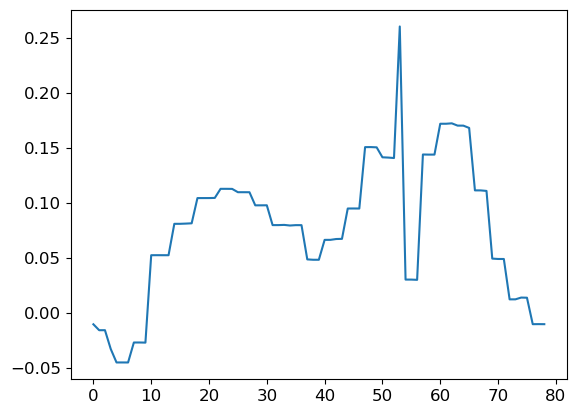

In [175]:
plt.plot(sla_ctd_diff)

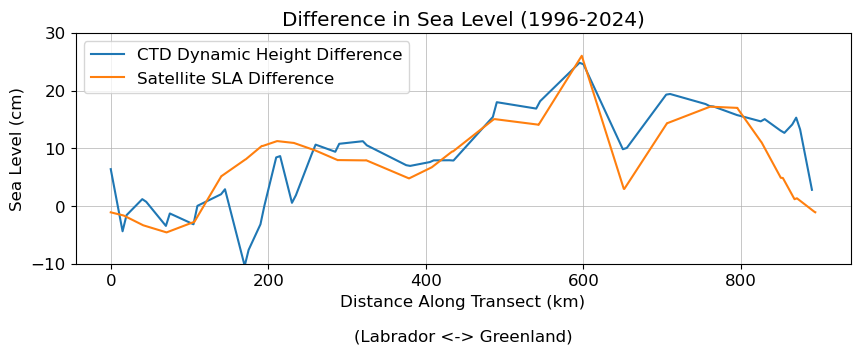

In [183]:
plt.rcParams['font.size'] = 12
plt.figure(figsize=[10,3])

diff = ar7w_2024_dynH.values - ar7w_1996_dynH.values

plt.plot(diff_smooth.distance_along_transect, diff_smooth*100, label='CTD Dynamic Height Difference')
plt.grid(linewidth=0.5)

plt.plot(ar7w_1996_dynH.distance_along_transect, sla_ctd_diff*100, label='Satellite SLA Difference')
plt.legend()
plt.ylim(-10,30)

plt.ylabel('Sea Level (cm)')
plt.xlabel('Distance Along Transect (km)\n\n(Labrador <-> Greenland)')
plt.title('Difference in Sea Level (1996-2024)');